In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandarallel import pandarallel
import wandb
import ast
import seaborn as sns

pandarallel.initialize()

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [18]:
api = wandb.Api()
entity, project = "dxtvzw", "ECAL optimization"
runs = api.runs(entity + "/" + project)

summary_list, config_list, name_list, group_list = [], [], [], []
for run in runs:
    # .summary contains output keys/values for
    # metrics such as accuracy.
    #  We call ._json_dict to omit large files
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append({k: v for k, v in run.config.items() if not k.startswith("_")})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

    # .group is the group name
    group_list.append(run.group)

runs_df = pd.DataFrame(
    {"summary": summary_list, "config": config_list, "name": name_list, "group": group_list}
)

runs_df.to_csv("project.csv")

In [2]:
runs_df = pd.read_csv("project.csv")

runs_df = runs_df.dropna()

runs_df.loc[:, 'summary'] = runs_df['summary'].parallel_apply(lambda row: ast.literal_eval(row))

runs_df = runs_df[runs_df['summary'].astype(bool)]

In [3]:
runs_df

,Unnamed: 0,summary,config,name,group
0,0,{'parameters/model.conv_proj.bias': {'_type': ...,"{'data': {'test_size': 0.2, 'batch_size': 512,...",grateful-moon-1454,exp6_40x40
1,1,{'parameters/model.encoder.layers.encoder_laye...,"{'data': {'test_size': 0.2, 'batch_size': 512,...",fluent-leaf-1447,exp6_40x40
2,2,{'parameters/model.encoder.layers.encoder_laye...,"{'data': {'test_size': 0.2, 'batch_size': 512,...",fearless-mountain-1447,exp6_40x40
3,3,{'gradients/model.encoder.layers.encoder_layer...,"{'data': {'test_size': 0.2, 'batch_size': 512,...",warm-elevator-1452,exp6_40x40
4,4,{'gradients/model.encoder.pos_embedding': {'va...,"{'data': {'test_size': 0.2, 'batch_size': 512,...",clean-glade-1447,exp6_40x40
...,...,...,...,...,...
1380,1380,{'scatter_MAE_table': {'_latest_artifact_path'...,"{'data': {'test_size': 0.2, 'batch_size': 512,...",amber-disco-70,exp1_vit_10x10
1381,1381,{'gradients/model.encoder.layers.encoder_layer...,"{'data': {'test_size': 0.2, 'batch_size': 512,...",wandering-darkness-71,exp1_vit_10x10
1382,1382,"{'RMSE_E eng': 0.01949208416044712, 'gradients...","{'data': {'test_size': 0.2, 'batch_size': 512,...",fresh-frost-76,exp1_vit_10x10
1383,1383,{'scatter_MAE_table': {'_latest_artifact_path'...,"{'data': {'test_size': 0.2, 'batch_size': 512,...",sandy-microwave-74,exp1_vit_10x10


In [4]:
runs_df.iloc[3]['summary']['RMSE_E eng']


0.022588863968849186

In [45]:
sensor_size = 60.6
shapes_int = [10, 15, 20, 25, 30, 40]
shapes = [f"{shape}x{shape}" for shape in shapes_int]
cell_size = {f"{shape}x{shape}": sensor_size / shape for shape in shapes_int}

def convert(val, shape: str):
    return val * 2 ** 0.5 * cell_size[shape]

### Experiment 1

In [14]:
''' latex format
    \textsf{Референсная модель} & $\mathcal{L}_{total}$ & 0.4894 &   0.3775 &  0.4263 &     0.4824 &    0.3683 & 0 \\
    {} & $\mathcal{L}_{eng}$ & 0.4894 &   0.3775 &  0.4263 &     0.4824 &    0.3683 & 0 \\
    {} & $\mathcal{L}_{pos}$ & 0.4894 &   0.3775 &  0.4263 &     0.4824 &    0.3683 & 0 \\
'''

dir = "raw/exp1"
paths = {
    "eng": "RMSE_E_eng.txt",
    "pos": "RMSE_pos.txt",
    "total": "val_total.txt",
}

shapes = set()

per_model = {}
for loss, path in paths.items():
    with open(os.path.join(dir, path), 'r') as f:
        for line in f:
            _, exp_name, value = line.strip().split()
            _, model, shape = exp_name.split('_')
            if model not in per_model:
                per_model[model] = {}
            if loss not in per_model[model]:
                per_model[model][loss] = {}
            per_model[model][loss][shape] = float(value)

            shapes.add(shape)

shapes = list(shapes)
shapes.sort()

models = {
    "AnaModel": "AnaModel",
    "LinearModel": "LinReg",
    "MyResnet18": "Resnet18",
    "MyCNN": "CNN",
    "MyViT": "ViT",
}

for model, new_name in models.items():
    data = per_model[model]

    # changing L_{pos} to be in centimeters
    for shape in shapes:
        data['pos'][shape] = convert(data['pos'][shape], shape)
        data['total'][shape] = 0.5 * data['eng'][shape] + 0.5 * data['pos'][shape]

    print("\\textsf{", new_name, "} & ", "$\mathcal{L}_{\mathsf{total}}$", sep='', end=' ')
    for shape in shapes:
        print("& " "$\\mathsf{", f"{data['total'][shape]:0.4f}", "}$", sep='', end=' ')
    print("\\\\")
    print("{} & $\mathcal{L}_{\mathsf{eng}}$", end=' ')
    for shape in shapes:
        print("& " "$\\mathsf{", f"{data['eng'][shape]:0.4f}", "}$", sep='', end=' ')
    print("\\\\")
    print("{} & $\mathcal{L}_{\mathsf{pos}}$", end=' ')
    for shape in shapes:
        print("& " "$\\mathsf{", f"{data['pos'][shape]:0.4f}", "}$", sep='', end=' ')
    print("\\\\")
    print("\\midrule")

\textsf{AnaModel} & $\mathcal{L}_{\mathsf{total}}$ & $\mathsf{0.4562}$ & $\mathsf{0.2444}$ & $\mathsf{0.1643}$ & $\mathsf{0.1263}$ & $\mathsf{0.1055}$ & $\mathsf{0.0878}$ \\
{} & $\mathcal{L}_{\mathsf{eng}}$ & $\mathsf{0.0213}$ & $\mathsf{0.0221}$ & $\mathsf{0.0226}$ & $\mathsf{0.0229}$ & $\mathsf{0.0220}$ & $\mathsf{0.0222}$ \\
{} & $\mathcal{L}_{\mathsf{pos}}$ & $\mathsf{0.8911}$ & $\mathsf{0.4667}$ & $\mathsf{0.3059}$ & $\mathsf{0.2297}$ & $\mathsf{0.1890}$ & $\mathsf{0.1533}$ \\
\midrule
\textsf{LinReg} & $\mathcal{L}_{\mathsf{total}}$ & $\mathsf{0.5438}$ & $\mathsf{0.3704}$ & $\mathsf{0.2807}$ & $\mathsf{0.2282}$ & $\mathsf{0.1936}$ & $\mathsf{0.1485}$ \\
{} & $\mathcal{L}_{\mathsf{eng}}$ & $\mathsf{0.0213}$ & $\mathsf{0.0221}$ & $\mathsf{0.0226}$ & $\mathsf{0.0231}$ & $\mathsf{0.0221}$ & $\mathsf{0.0223}$ \\
{} & $\mathcal{L}_{\mathsf{pos}}$ & $\mathsf{1.0664}$ & $\mathsf{0.7188}$ & $\mathsf{0.5388}$ & $\mathsf{0.4333}$ & $\mathsf{0.3651}$ & $\mathsf{0.2747}$ \\
\midrule
\textsf{

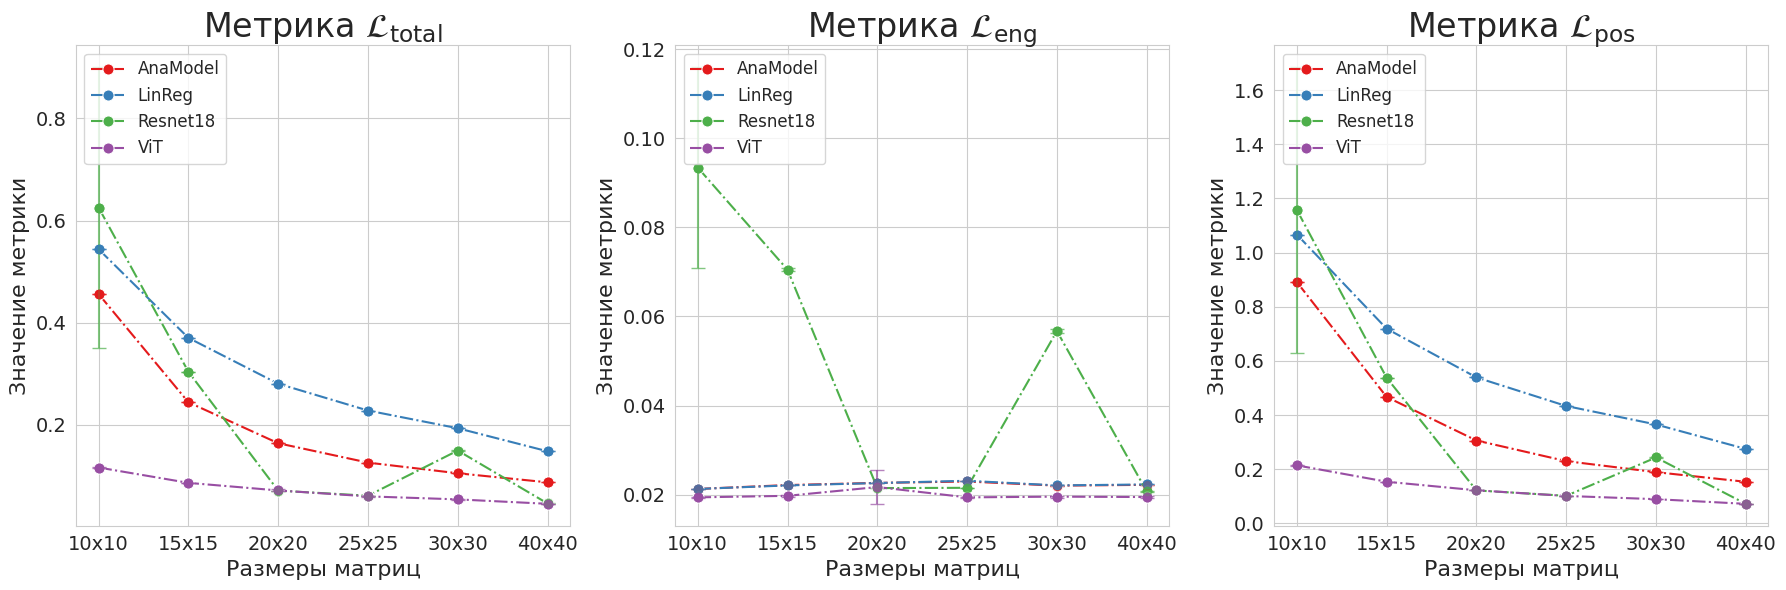

In [58]:
cur_df = runs_df.loc[runs_df['group'].str.startswith('exp1')]

models = {
    "AnaModel": "AnaModel",
    "LinearModel": "LinReg",
    "MyResnet18": "Resnet18",
    "MyViT": "ViT",
    # "MyCNN": "CNN",
}

shapes = sorted(list(set(cur_df['group'].str.split('_').apply(lambda x: x[2]).tolist())))

metrics = {
    'val_total': '$\mathcal{L}_{\mathsf{total}}$',
    'RMSE_E eng': '$\mathcal{L}_{\mathsf{eng}}$',
    'RMSE pos': '$\mathcal{L}_{\mathsf{pos}}$',
}

sns.set_style("whitegrid")

palette = sns.color_palette("Set1", len(models))

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, (metric, latex_metric) in zip(axes, metrics.items()):
    for i, (old_name, name) in enumerate(models.items()):
        values = {shape: [] for shape in shapes}

        for shape in shapes:
            tmp = cur_df.loc[cur_df['group'] == f"exp1_{old_name}_{shape}"]

            tmp = tmp[tmp['summary'].apply(lambda x: metric in x)]

            # changing L_{pos} to be in centimeters
            tmp['val_total'] = tmp['summary'].apply(lambda x: x['val_total'])
            tmp['RMSE_E eng'] = tmp['summary'].apply(lambda x: x['RMSE_E eng'])
            tmp['RMSE pos'] = tmp['summary'].apply(lambda x: x['RMSE pos'])

            tmp['RMSE pos'] = convert(tmp['RMSE pos'], shape)
            tmp['val_total'] = 0.5 * tmp['RMSE_E eng'] + 0.5 * tmp['RMSE pos']

            values[shape] = tmp[metric].tolist()

        sorted_values = sorted(values.items(), key=lambda x: shapes.index(x[0]))

        sorted_shapes, sorted_metrics = zip(*sorted_values)

        sns.lineplot(
            x=sorted_shapes,
            y=[np.mean(x) for x in sorted_metrics],
            ax=ax,
            color=palette[i],
            label=name,
            marker='o',
            markersize=8,
            linestyle='-.',
            linewidth=1.5,
        )
        
        ax.errorbar(
            x=shapes,
            y=[np.mean(x) for x in sorted_metrics],
            yerr=[np.std(x) for x in sorted_metrics],
            fmt='o',
            color=palette[i],
            capsize=5,
            alpha=0.7
        )

    ax.set_title(f"Метрика {latex_metric}", fontsize=24)
    ax.set_xlabel('Размеры матриц', fontsize=16)
    ax.set_ylabel('Значение метрики', fontsize=16)
    ax.legend(fontsize=12, loc='upper left')
    ax.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()
plt.savefig('../graphics/models_comp')
plt.show()

### Experiment 2

In [23]:
dir = "raw/exp2"
paths = {
    "eng": "RMSE_E_eng.txt",
    "pos": "RMSE_pos.txt",
}

shapes = set()

per_loss = {}
for metric, path in paths.items():
    with open(os.path.join(dir, path), 'r') as f:
        for line in f:
            _, exp_name, value = line.strip().split()
            fields = exp_name.split('_')
            shape = fields[1]
            loss_fn = fields[2]
            if len(fields) == 4:
                loss_fn += '_' + fields[3]

            if loss_fn not in per_loss:
                per_loss[loss_fn] = {}
            if metric not in per_loss[loss_fn]:
                per_loss[loss_fn][metric] = {}
            per_loss[loss_fn][metric][shape] = float(value)

            shapes.add(shape)

shapes = list(shapes)
shapes.sort()

eng_losses = [
    "RMSE_E",
    "MAE_E",
    "RMSLE",
    "RMSE",
]

def pretty_print(loss_fn: str):
    return loss_fn.replace('_', '/')

for loss_fn in eng_losses:
    data = per_loss[loss_fn]

    # changing L_{pos} to be in centimeters
    for shape in shapes:
        data['pos'][shape] = convert(data['pos'][shape], shape)

    print("\\textsf{", pretty_print(loss_fn), "} &", sep='', end=' ')
    print("$\mathcal{L}_{\mathsf{eng}}$", end=' ')
    for shape in shapes:
        print("& " "$\\mathsf{", f"{data['eng'][shape]:0.4f}", "}$", sep='', end=' ')
    print("\\\\")
    print("{} & $\mathcal{L}_{\mathsf{pos}}$", end=' ')
    for shape in shapes:
        print("& " "$\\mathsf{", f"{data['pos'][shape]:0.4f}", "}$", sep='', end=' ')
    print("\\\\")
    if loss_fn != eng_losses[-1]:
        print("\\midrule")

\textsf{RMSE/E} & $\mathcal{L}_{\mathsf{eng}}$ & $\mathsf{0.0194}$ & $\mathsf{0.0198}$ & $\mathsf{0.0201}$ & $\mathsf{0.0192}$ & $\mathsf{0.0193}$ & $\mathsf{0.0195}$ \\
{} & $\mathcal{L}_{\mathsf{pos}}$ & $\mathsf{0.2142}$ & $\mathsf{0.1540}$ & $\mathsf{0.1218}$ & $\mathsf{0.1008}$ & $\mathsf{0.0886}$ & $\mathsf{0.0723}$ \\
\midrule
\textsf{MAE/E} & $\mathcal{L}_{\mathsf{eng}}$ & $\mathsf{0.0198}$ & $\mathsf{0.0200}$ & $\mathsf{0.0204}$ & $\mathsf{0.0199}$ & $\mathsf{0.0199}$ & $\mathsf{0.0200}$ \\
{} & $\mathcal{L}_{\mathsf{pos}}$ & $\mathsf{0.2147}$ & $\mathsf{0.1534}$ & $\mathsf{0.1218}$ & $\mathsf{0.1007}$ & $\mathsf{0.0892}$ & $\mathsf{0.0721}$ \\
\midrule
\textsf{RMSLE} & $\mathcal{L}_{\mathsf{eng}}$ & $\mathsf{0.0193}$ & $\mathsf{0.0196}$ & $\mathsf{0.0204}$ & $\mathsf{0.0191}$ & $\mathsf{0.0194}$ & $\mathsf{0.0194}$ \\
{} & $\mathcal{L}_{\mathsf{pos}}$ & $\mathsf{0.2137}$ & $\mathsf{0.1534}$ & $\mathsf{0.1221}$ & $\mathsf{0.1006}$ & $\mathsf{0.0885}$ & $\mathsf{0.0724}$ \\
\mi

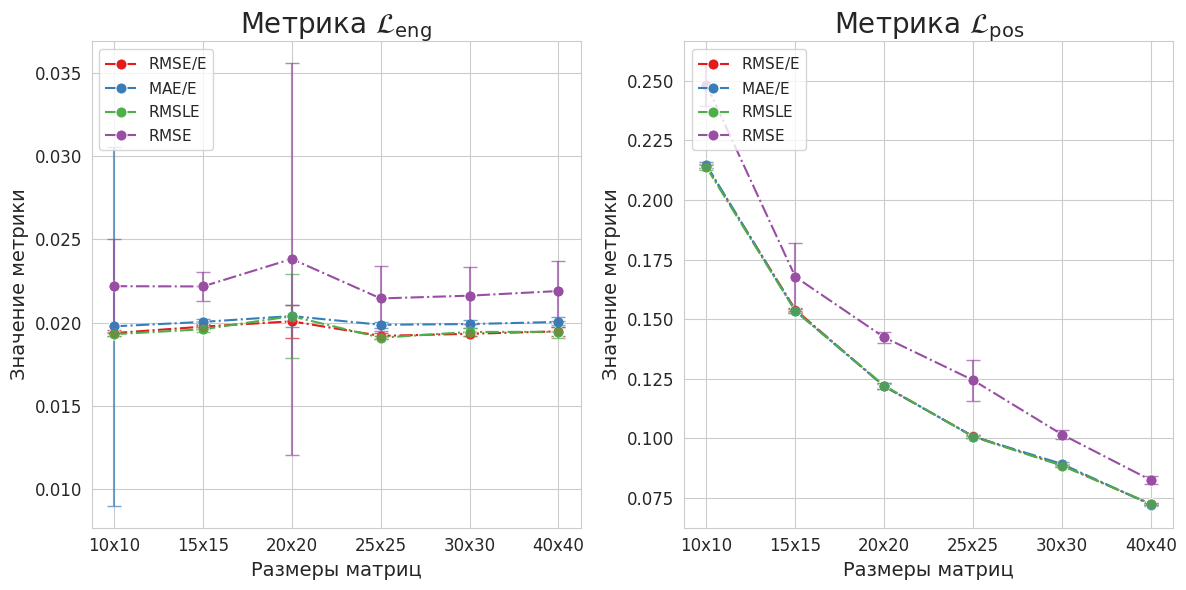

In [26]:
cur_df = runs_df.loc[runs_df['group'].str.startswith('exp2')]

shapes = sorted(list(set(cur_df['group'].str.split('_').apply(lambda x: x[1]).tolist())))

losses = {
    "RMSE_E": "$\\mathsf{RMSE/E}$",
    "MAE_E": "$\\mathsf{MAE/E}$",
    "RMSLE": "$\\mathsf{RMSLE}$",
    "RMSE": "$\\mathsf{RMSE}$",
}

metrics = {
    'RMSE_E eng': '$\mathcal{L}_{\mathsf{eng}}$',
    'RMSE pos': '$\mathcal{L}_{\mathsf{pos}}$',
}

sns.set_style("whitegrid")

palette = sns.color_palette("Set1", len(models))

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for ax, (metric, latex_metric) in zip(axes, metrics.items()):
    for i, (df_name, name) in enumerate(losses.items()):
        values = {shape: [] for shape in shapes}

        for shape in shapes:
            tmp = cur_df.loc[cur_df['group'] == f"exp2_{shape}_{df_name}"]
            tmp = tmp[tmp['summary'].apply(lambda x: metric in x)]

            # changing L_{pos} to be in centimeters
            tmp['val_total'] = tmp['summary'].apply(lambda x: x['val_total'])
            tmp['RMSE_E eng'] = tmp['summary'].apply(lambda x: x['RMSE_E eng'])
            tmp['RMSE pos'] = tmp['summary'].apply(lambda x: x['RMSE pos'])

            tmp['RMSE pos'] = convert(tmp['RMSE pos'], shape)
            tmp['val_total'] = 0.5 * tmp['RMSE_E eng'] + 0.5 * tmp['RMSE pos']

            values[shape] = tmp[metric].tolist()

        sorted_values = sorted(values.items(), key=lambda x: shapes.index(x[0]))

        sorted_shapes, sorted_metrics = zip(*sorted_values)

        # if (metric == "RMSE_E eng") and (df_name == "MAE_E"):
        #     print(sorted_metrics)

        sns.lineplot(
            x=sorted_shapes,
            y=[np.median(x) for x in sorted_metrics],
            ax=ax,
            color=palette[i],
            label=name,
            marker='o',
            markersize=8,
            linestyle='-.',
            linewidth=1.5,
        )
        
        ax.errorbar(
            x=shapes,
            y=[np.median(x) for x in sorted_metrics],
            yerr=[np.std(x) for x in sorted_metrics],
            fmt='o',
            color=palette[i],
            capsize=5,
            alpha=0.7
        )

    ax.set_title(f"Метрика {latex_metric}", fontsize=20)
    ax.set_xlabel('Размеры матриц', fontsize=14)
    ax.set_ylabel('Значение метрики', fontsize=14)
    ax.legend(fontsize=11, loc='upper left')
    ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.savefig('../graphics/loss_comp')
plt.show()

### Experiment 3

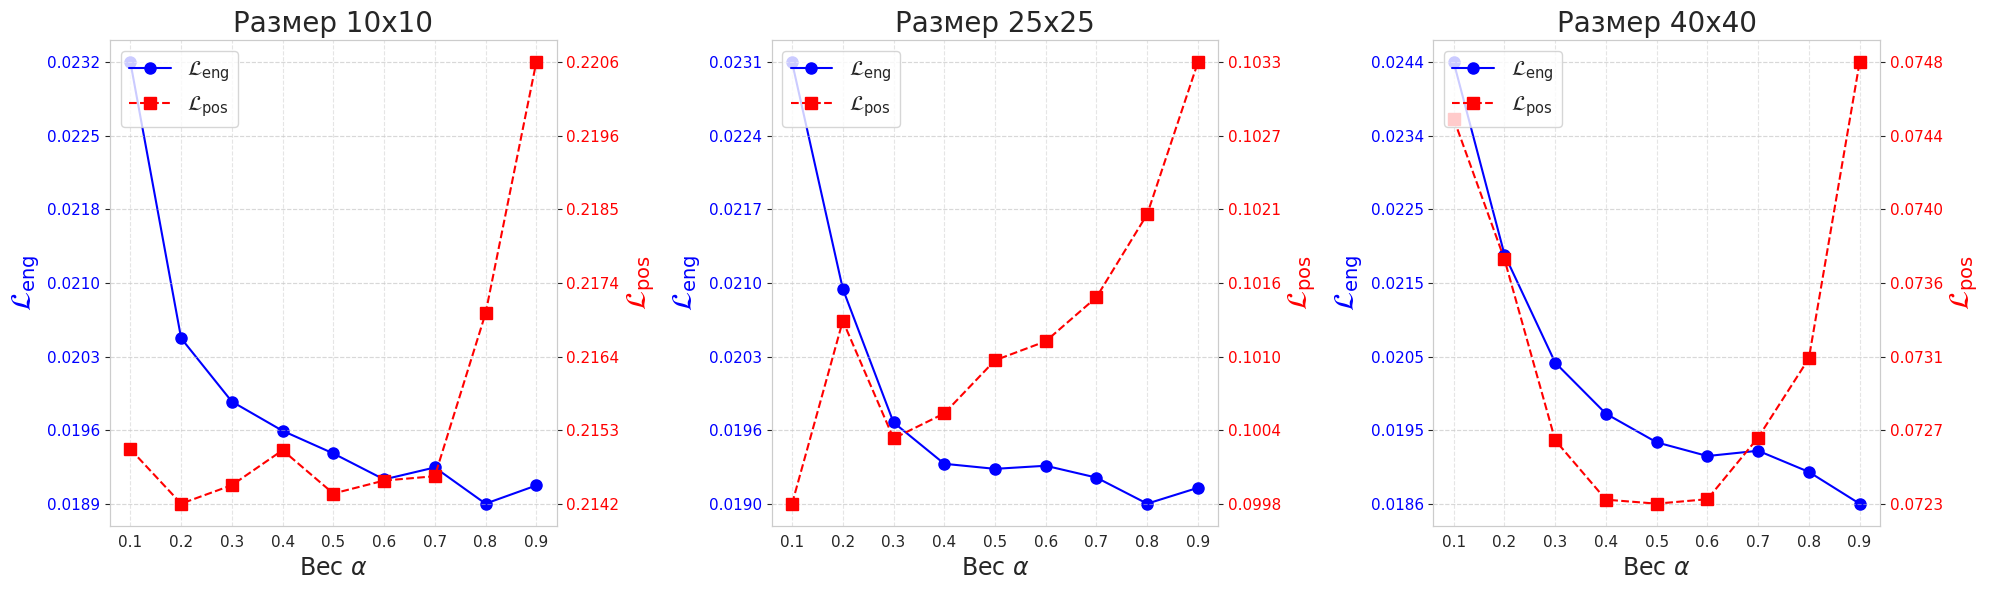

In [30]:
from matplotlib.ticker import FormatStrFormatter

dir = "raw/exp3"
paths = {
    "eng": "RMSE_E_eng.txt",
    "pos": "RMSE_pos.txt",
}

shapes = set()
alphas = set()

data = {key: {} for key in paths.keys()}

for metric, path in paths.items():
    with open(os.path.join(dir, path), 'r') as f:
        for line in f:
            _, exp_name, value = line.strip().split()
            _, shape, alpha = exp_name.split('_')

            alpha = float(alpha)
            value = float(value)

            if shape not in data[metric]:
                data[metric][shape] = {}
            
            data[metric][shape][alpha] = value

            alphas.add(alpha)
            shapes.add(shape)

shapes = list(shapes)
shapes.sort()

alphas = list(alphas)
alphas.sort()

fig, axs = plt.subplots(1, 3, figsize=(20, 6))  # 1 row, 3 columns

for i, (ax1, shape) in enumerate(zip(axs, shapes)):
    arr_eng = sorted(list(data['eng'][shape].items()), key=lambda x: x[0])
    arr_eng = arr_eng[1:-1]

    arr_pos = sorted(list(data['pos'][shape].items()), key=lambda x: x[0])

    # changing L_{pos} to be in centimeters
    tmp = [x[1] for x in arr_pos]
    tmp = convert(np.array(tmp), shape)
    arr_pos = [(alpha, new_val) for (alpha, old_val), new_val in zip(arr_pos, tmp)]

    arr_pos = arr_pos[1:-1]

    ax1.plot([x[0] for x in arr_eng], [x[1] for x in arr_eng], color='blue', linestyle='-', marker='o', markersize=8, label='$\mathcal{L}_{\mathsf{eng}}$')
    ax1.set_ylabel('$\mathcal{L}_{\mathsf{eng}}$', color='blue', fontsize=20)
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_yticks(np.linspace(np.min([x[1] for x in arr_eng]), np.max([x[1] for x in arr_eng]), 7))
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))

    ax2 = ax1.twinx()
    ax2.plot([x[0] for x in arr_pos], [x[1] for x in arr_pos], color='red', linestyle='--', marker='s', markersize=8, label='$\mathcal{L}_{\mathsf{pos}}$')
    ax2.set_ylabel('$\mathcal{L}_{\mathsf{pos}}$', color='red', fontsize=20)
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.set_yticks(np.linspace(np.min([x[1] for x in arr_pos]), np.max([x[1] for x in arr_pos]), 7))
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))

    ax1.set_xlabel('Вес $\\alpha$', fontsize=17)
    ax1.set_title(f"Размер {shape}", fontsize=20)

    ax1.tick_params(axis='both', which='both', labelsize=11)
    ax2.tick_params(axis='both', which='both', labelsize=11)

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=15)

    ax1.grid(which='major', linestyle='--', alpha=0.5)
    ax2.grid(which='major', linestyle='--', alpha=0.5)

# plt.subplots_adjust(wspace=0.5)
plt.tight_layout()

plt.savefig('../graphics/exp3_alpha')
plt.show()

In [33]:
cur_df = runs_df.loc[runs_df['group'].str.startswith('exp3')]

all_shapes = sorted(cur_df['group'].apply(lambda x: x.split('_')[1]).unique().tolist())
all_alphas = sorted(cur_df['group'].apply(lambda x: x.split('_')[2]).unique().tolist())

all_shapes, all_alphas

(['10x10', '25x25', '40x40'],
 ['0.0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0'])

In [34]:
num_runs = cur_df.groupby(cur_df['group'])['group'].count().unique()[0]

metrics = {
    "eng": "RMSE_E eng",
    "pos": "RMSE pos",
}

data = {}

for metric, df_name in metrics.items():
    for shape in all_shapes:
        for alpha in all_alphas:
            if metric not in data:
                data[metric] = {}
            if shape not in data[metric]:
                data[metric][shape] = {}
            
            data[metric][shape][alpha] = cur_df[cur_df['group'] == f"exp3_{shape}_{alpha}"]['summary'].apply(lambda x: x[df_name]).tolist()

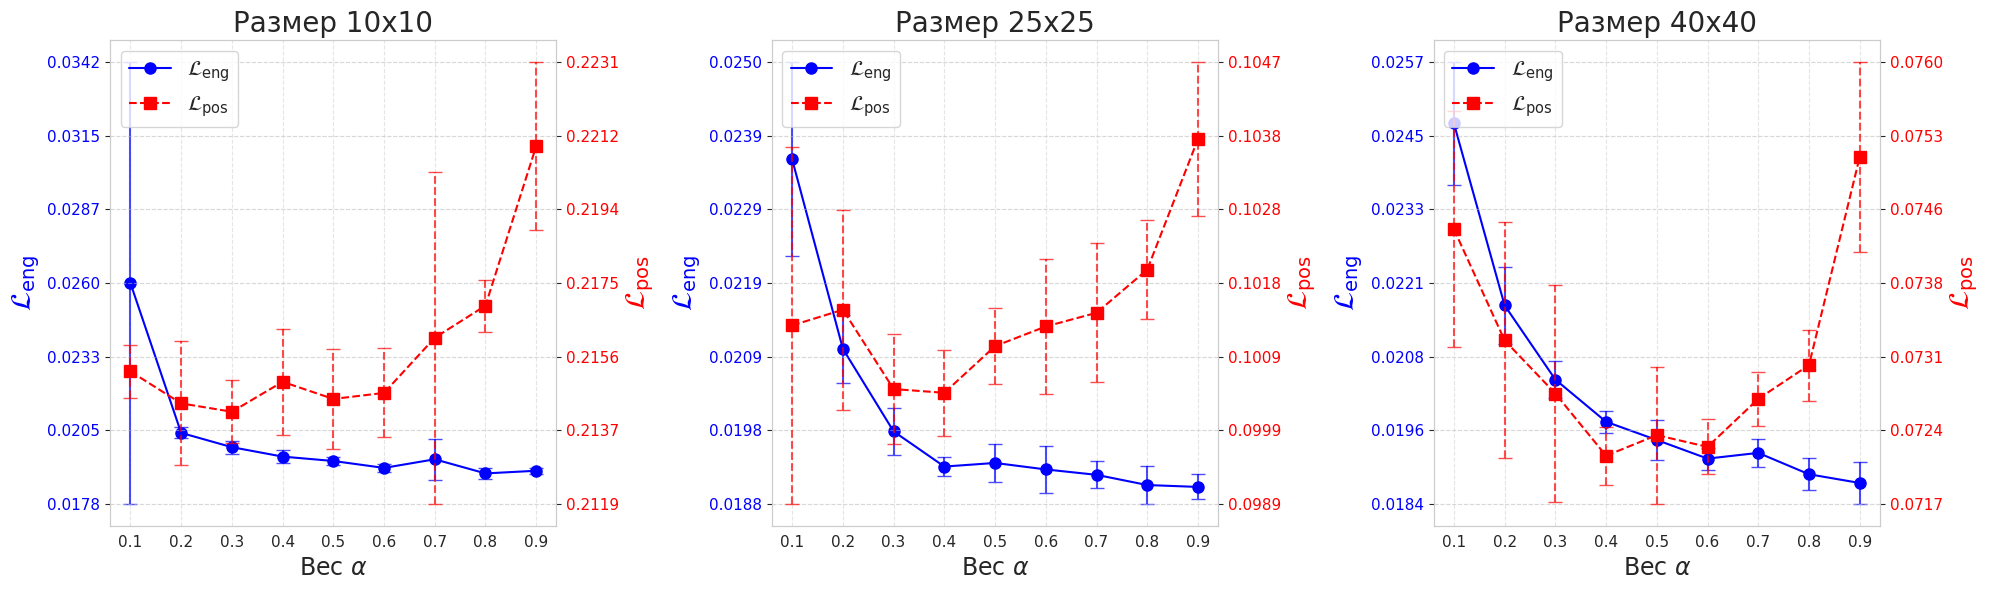

In [36]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))  # 1 row, 3 columns

aggr_func = np.mean

for i, (ax1, shape) in enumerate(zip(axs, shapes)):
    arr_eng = sorted(list(data['eng'][shape].items()), key=lambda x: x[0])
    arr_eng = arr_eng[1:-1]

    arr_pos = sorted(list(data['pos'][shape].items()), key=lambda x: x[0])

    # changing L_{pos} to be in centimeters
    tmp = [x[1] for x in arr_pos]
    tmp = convert(np.array(tmp), shape)
    arr_pos = [(alpha, new_val) for (alpha, old_val), new_val in zip(arr_pos, tmp)]
    
    arr_pos = arr_pos[1:-1]

    ax1.plot([x[0] for x in arr_eng], [aggr_func(x[1]) for x in arr_eng], color='blue', linestyle='-', marker='o', markersize=8, label='$\mathcal{L}_{\mathsf{eng}}$')
    ax1.errorbar(
        x=[x[0] for x in arr_eng],
        y=[aggr_func(x[1]) for x in arr_eng],
        yerr=[np.std(x[1]) for x in arr_eng],
        fmt='',
        color='blue',
        linestyle='',
        capsize=5,
        alpha=0.7
    )

    ax1.set_ylabel('$\mathcal{L}_{\mathsf{eng}}$', color='blue', fontsize=20)
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_yticks(np.linspace(
        np.min([aggr_func(x[1]) - np.std(x[1]) for x in arr_eng]),
        np.max([aggr_func(x[1]) + np.std(x[1]) for x in arr_eng]),
        7))
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))


    ax2 = ax1.twinx()
    ax2.plot([x[0] for x in arr_pos], [aggr_func(x[1]) for x in arr_pos], color='red', linestyle='--', marker='s', markersize=8, label='$\mathcal{L}_{\mathsf{pos}}$')
    ax2.errorbar(
        x=[x[0] for x in arr_pos],
        y=[aggr_func(x[1]) for x in arr_pos],
        yerr=[np.std(x[1]) for x in arr_pos],
        fmt='',
        color='red',
        linestyle='',
        capsize=5,
        alpha=0.7
    )[-1][0].set_linestyle('--')

    ax2.set_ylabel('$\mathcal{L}_{\mathsf{pos}}$', color='red', fontsize=20)
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.set_yticks(np.linspace(
        np.min([aggr_func(x[1]) - np.std(x[1]) for x in arr_pos]),
        np.max([aggr_func(x[1]) + np.std(x[1]) for x in arr_pos]),
        7))
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))

    ax1.set_xlabel('Вес $\\alpha$', fontsize=17)
    ax1.set_title(f"Размер {shape}", fontsize=20)

    ax1.tick_params(axis='both', which='both', labelsize=11)
    ax2.tick_params(axis='both', which='both', labelsize=11)

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=15)

    ax1.grid(which='major', linestyle='--', alpha=0.5)
    ax2.grid(which='major', linestyle='--', alpha=0.5)

# plt.subplots_adjust(wspace=0.5)
plt.tight_layout()

plt.savefig('../graphics/exp3_alpha_std')
plt.show()

### Experiment 4

In [100]:
dir = "raw/exp4"
paths = {
    "eng": "RMSE_E_eng.txt",
    "pos": "RMSE_pos.txt",
}

all_num_layers = set()
all_num_heads = set()
all_hidden_dim = set()

data = {key: {} for key in paths.keys()}

for metric, path in paths.items():
    with open(os.path.join(dir, path), 'r') as f:
        for line in f:
            _, exp_name, value = line.strip().split()
            _, num_layers, hidden_dim, num_heads = exp_name.split('_')
            num_layers = int(num_layers)
            hidden_dim = int(hidden_dim)
            num_heads = int(num_heads)

            all_num_layers.add(num_layers)
            all_num_heads.add(num_heads)
            all_hidden_dim.add(hidden_dim)


all_num_layers = sorted(list(all_num_layers))
all_num_heads = sorted(list(all_num_heads))
all_hidden_dim = sorted(list(all_hidden_dim))

num_layers_id, num_heads_id, hidden_dim_id = {}, {}, {}

for i, val in enumerate(all_num_layers):
    num_layers_id[val] = i

for i, val in enumerate(all_num_heads):
    num_heads_id[val] = i

for i, val in enumerate(all_hidden_dim):
    hidden_dim_id[val] = i

loss_val = {
    "eng": np.zeros((len(all_num_layers), len(all_num_heads), len(all_hidden_dim))),
    "pos": np.zeros((len(all_num_layers), len(all_num_heads), len(all_hidden_dim))),
}

for metric, path in paths.items():
    with open(os.path.join(dir, path), 'r') as f:
        for line in f:
            _, exp_name, value = line.strip().split()
            _, num_layers, hidden_dim, num_heads = exp_name.split('_')
            num_layers = int(num_layers)
            hidden_dim = int(hidden_dim)
            num_heads = int(num_heads)

            value = float(value)

            loss_val[metric][num_layers_id[num_layers], num_heads_id[num_heads], hidden_dim_id[hidden_dim]] = value

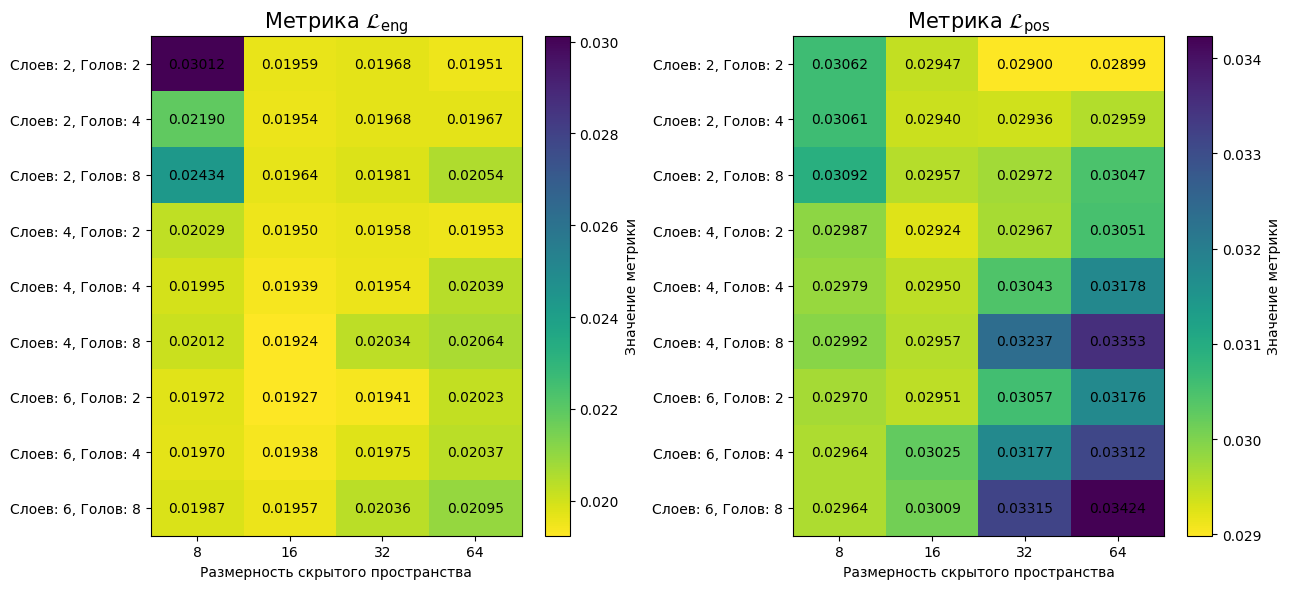

In [132]:
fig, axs = plt.subplots(1, 2, figsize=(13, 6))  # 1 row, 3 columns

for i, (ax, metric) in enumerate(zip(axs, ["eng", "pos"])):
    data = loss_val[metric]

    im = ax.imshow(data.reshape(data.shape[0] * data.shape[1], data.shape[2]), cmap='viridis_r', aspect='auto')

    # Add color bar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.set_label('Значение метрики')

    # Set ticks and labels
    ax.set_xticks(np.arange(data.shape[2]))
    ax.set_yticks(np.arange(data.shape[0] * data.shape[1]))  # Adjusted range for the last row
    ax.set_xticklabels(all_hidden_dim)
    ax.set_yticklabels(['Слоев: {}, Голов: {}'.format(layer, head) for layer in all_num_layers for head in all_num_heads])  # Added an empty label for padding

    # Rotate the tick labels and set their alignment.
    # plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            for k in range(data.shape[2]):
                text = ax.text(k, i * data.shape[1] + j, "{:.5f}".format(data[i, j, k]),
                            ha="center", va="center", color="black")

    metric_name = "$\mathcal{L}_{\mathsf{eng}}$" if metric == "eng" else "$\mathcal{L}_{\mathsf{pos}}$"
    ax.set_title(f"Метрика {metric_name}", fontsize=15)
    ax.set_xlabel('Размерность скрытого пространства')
    # ax.set_ylabel('Number of Layers and Heads')

plt.tight_layout()
plt.savefig('../graphics/exp4_model_params')
plt.show()

In [37]:
cur_df = runs_df.loc[runs_df['group'].str.startswith('exp4')]

all_num_layers = sorted(cur_df['group'].apply(lambda x: int(x.split('_')[1])).unique().tolist())
all_hidden_dim = sorted(cur_df['group'].apply(lambda x: int(x.split('_')[2])).unique().tolist())
all_num_heads = sorted(cur_df['group'].apply(lambda x: int(x.split('_')[3])).unique().tolist())

num_runs = cur_df.groupby(cur_df['group'])['group'].count().unique()[0]

loss_val = {
    "eng": np.zeros((len(all_num_layers), len(all_num_heads), len(all_hidden_dim), num_runs)),
    "pos": np.zeros((len(all_num_layers), len(all_num_heads), len(all_hidden_dim), num_runs)),
}

for i, num_layers in enumerate(all_num_layers):
    for j, num_heads in enumerate(all_num_heads):
        for k, hidden_dim in enumerate(all_hidden_dim):
            loss_val['eng'][i, j, k] = cur_df[cur_df['group'] == f"exp4_{num_layers}_{hidden_dim}_{num_heads}"]['summary'].apply(lambda x: x['RMSE_E eng']).tolist()
            loss_val['pos'][i, j, k] = cur_df[cur_df['group'] == f"exp4_{num_layers}_{hidden_dim}_{num_heads}"]['summary'].apply(lambda x: x['RMSE pos']).tolist()

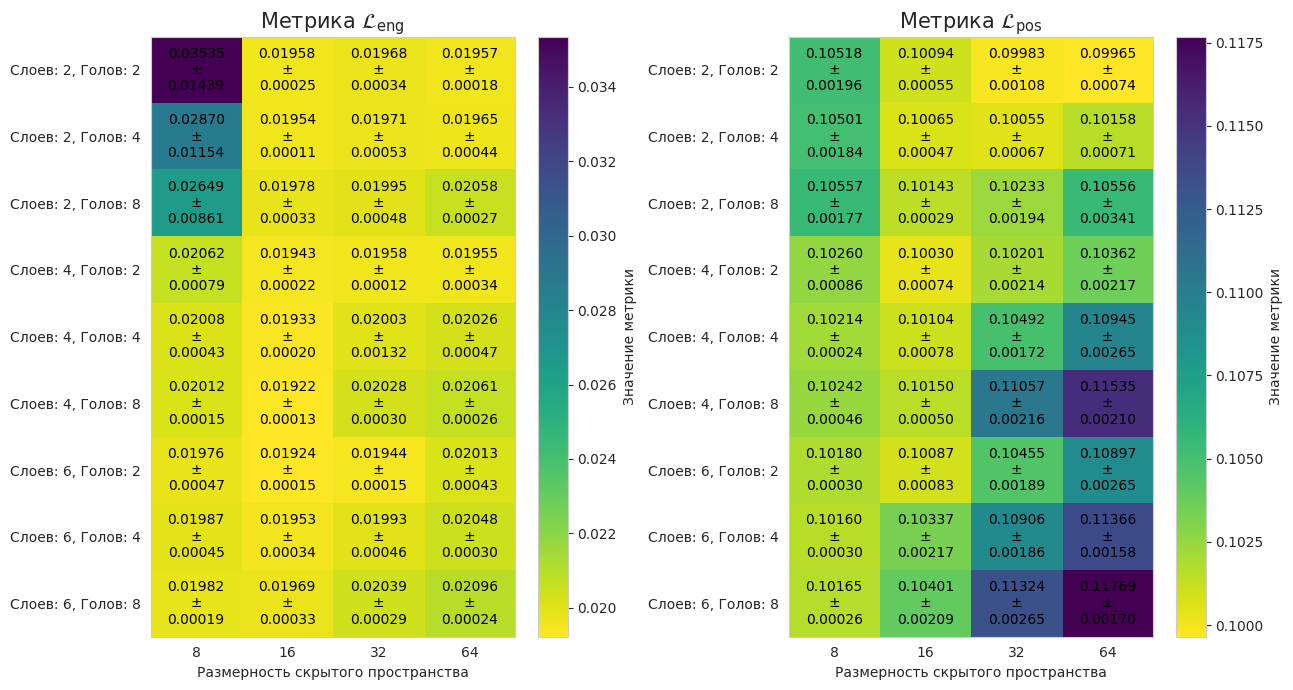

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(13, 7))  # 1 row, 3 columns

loss_val['pos'] = convert(loss_val['pos'], "25x25")

for i, (ax, metric) in enumerate(zip(axs, ["eng", "pos"])):
    data = loss_val[metric]

    im = ax.imshow(data.mean(-1).reshape(data.shape[0] * data.shape[1], data.shape[2]), cmap='viridis_r', aspect='auto')

    # Add color bar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.set_label('Значение метрики')

    # Set ticks and labels
    ax.set_xticks(np.arange(data.shape[2]))
    ax.set_yticks(np.arange(data.shape[0] * data.shape[1]))  # Adjusted range for the last row
    ax.set_xticklabels(all_hidden_dim)
    ax.set_yticklabels(['Слоев: {}, Голов: {}'.format(layer, head) for layer in all_num_layers for head in all_num_heads])  # Added an empty label for padding

    # Rotate the tick labels and set their alignment.
    # plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            for k in range(data.shape[2]):
                text = ax.text(k, i * data.shape[1] + j, f"{data[i, j, k].mean():.5f}\n$\pm$\n{data[i, j, k].std():.5f}",
                            ha="center", va="center", color="black")

    metric_name = "$\mathcal{L}_{\mathsf{eng}}$" if metric == "eng" else "$\mathcal{L}_{\mathsf{pos}}$"
    ax.set_title(f"Метрика {metric_name}", fontsize=15)
    ax.set_xlabel('Размерность скрытого пространства')
    ax.grid(False)

plt.tight_layout()
plt.savefig('../graphics/exp4_model_params_std')
plt.show()

### Experiment 5

In [42]:
dir = "raw/exp5"
paths = [
    "train_eng.txt",
    "train_pos.txt",
    "val_eng.txt",
    "val_pos.txt",
]

data = {}

for path in paths:
    dataset_metric, _ = path.split('.')
    dataset, metric = dataset_metric.split('_')
    with open(os.path.join(dir, path), 'r') as f:
        for line in f:
            _, exp_name, value = line.strip().split()
            value = float(value)
            _, shape, use_flip, use_rot = exp_name.split('_')
            use_flip = use_flip == "True"
            use_rot = use_rot == "True"

            data[(shape, dataset, metric, use_flip, use_rot)] = value
            # print(shape, dataset, metric, use_flip, use_rot, value)

augs = [
    (False, False),
    (True, False),
    (False, True),
    (True, True)
]
shapes = ["15x15", "25x25"]
datasets = ["train", "val"]
metrics = ["eng", "pos"]

for use_flip, use_rot in augs:
    if use_flip:
        print('\\cmark & ', sep='', end='')
    else:
        print('\\xmark & ', sep='', end='')
    if use_rot:
        print('\\cmark ', sep='', end='')
    else:
        print('\\xmark ', sep='', end='')
    for shape in shapes:
        for dataset in datasets:
            for metric in metrics:
                value = data[(shape, dataset, metric, use_flip, use_rot)]
                if metric == "pos":
                    value = convert(value, shape)
                print("& " "$\\mathsf{", f"{value:0.4f}", "}$", sep='', end=' ')
    print('\\\\')

\xmark & \xmark & $\mathsf{0.0182}$ & $\mathsf{0.1456}$ & $\mathsf{0.0217}$ & $\mathsf{0.1535}$ & $\mathsf{0.0181}$ & $\mathsf{0.0999}$ & $\mathsf{0.0192}$ & $\mathsf{0.1008}$ \\
\cmark & \xmark & $\mathsf{0.0186}$ & $\mathsf{0.1481}$ & $\mathsf{0.0194}$ & $\mathsf{0.1537}$ & $\mathsf{0.0186}$ & $\mathsf{0.1012}$ & $\mathsf{0.0191}$ & $\mathsf{0.1003}$ \\
\xmark & \cmark & $\mathsf{0.0185}$ & $\mathsf{0.1476}$ & $\mathsf{0.0193}$ & $\mathsf{0.1528}$ & $\mathsf{0.0186}$ & $\mathsf{0.1013}$ & $\mathsf{0.0189}$ & $\mathsf{0.1005}$ \\
\cmark & \cmark & $\mathsf{0.0185}$ & $\mathsf{0.1475}$ & $\mathsf{0.0192}$ & $\mathsf{0.1525}$ & $\mathsf{0.0186}$ & $\mathsf{0.1012}$ & $\mathsf{0.0189}$ & $\mathsf{0.1001}$ \\


### Experiment 6

In [50]:
dir = "raw/exp6"
paths = {
    "eng": "RMSE_E_eng.txt",
    "pos": "RMSE_pos.txt",
    "rel_eng": "MAE_E_eng.txt",
    "total": "val_total.txt",
}

shapes = set()

data = {}
for loss, path in paths.items():
    with open(os.path.join(dir, path), 'r') as f:
        for line in f:
            _, exp_name, value = line.strip().split()
            _, shape = exp_name.split('_')
            value = float(value)

            if loss not in data:
                data[loss] = {}
            data[loss][shape] = value

            shapes.add(shape)

shapes = list(shapes)
shapes.sort()

print("$\mathcal{L}_{\mathsf{total}}$", sep='', end=' ')
for shape in shapes:
    value = 0.5 * data['eng'][shape] + 0.5 * convert(data['pos'][shape], shape)
    print("& $\\mathsf{", f"{value:0.4f}", "}$", sep='', end=' ')
print("\\\\")

print("$\mathcal{L}_{\mathsf{eng}}$", end=' ')
for shape in shapes:
    print("& $\\mathsf{", f"{data['eng'][shape]:0.4f}", "}$", sep='', end=' ')
print("\\\\")

print("$\mathcal{L}_{\mathsf{pos}}$", end=' ')
for shape in shapes:
    print("& $\\mathsf{", f"{convert(data['pos'][shape], shape):0.4f}", "}$", sep='', end=' ')
print("\\\\")

print("\\textsf{Размер одной ячейки}", end=' ')
for shape in shapes:
    # height, width = shape.split('x')
    # height = int(height)
    # width = int(width)
    # cell_size = sensor_size / height
    print("& $\\mathsf{", f"{cell_size[shape]:0.4f}", "}$", sep='', end=' ')
print("\\\\")

print("$\\textsf{MAE/E}_{\\textsf{eng}}$", end=' ')
for shape in shapes:
    print("& $\\mathsf{", f"{data['rel_eng'][shape]:0.4f}", "}$", sep='', end=' ')
print("\\\\")

# sensor_size = 60.6

# print("$\overline{\mathcal{L}}_{\mathsf{pos}}$", end=' ')
# for shape in shapes:
#     height, width = shape.split('x')
#     height = int(height)
#     width = int(width)
#     cell_size = sensor_size / height
#     cur = data['pos'][shape]
#     cur = cur * 2 ** 0.5 * cell_size
#     print("& $\\mathsf{", f"{cur:0.4f}", "}$", sep='', end=' ')
# print("\\\\")

$\mathcal{L}_{\mathsf{total}}$ & $\mathsf{0.1153}$ & $\mathsf{0.0852}$ & $\mathsf{0.0702}$ & $\mathsf{0.0588}$ & $\mathsf{0.0535}$ & $\mathsf{0.0453}$ \\
$\mathcal{L}_{\mathsf{eng}}$ & $\mathsf{0.0189}$ & $\mathsf{0.0189}$ & $\mathsf{0.0194}$ & $\mathsf{0.0187}$ & $\mathsf{0.0189}$ & $\mathsf{0.0190}$ \\
$\mathcal{L}_{\mathsf{pos}}$ & $\mathsf{0.2117}$ & $\mathsf{0.1515}$ & $\mathsf{0.1211}$ & $\mathsf{0.0989}$ & $\mathsf{0.0881}$ & $\mathsf{0.0715}$ \\
\textsf{Размер одной ячейки} & $\mathsf{6.0600}$ & $\mathsf{4.0400}$ & $\mathsf{3.0300}$ & $\mathsf{2.4240}$ & $\mathsf{2.0200}$ & $\mathsf{1.5150}$ \\
$\textsf{MAE/E}_{\textsf{eng}}$ & $\mathsf{0.0131}$ & $\mathsf{0.0127}$ & $\mathsf{0.0132}$ & $\mathsf{0.0124}$ & $\mathsf{0.0130}$ & $\mathsf{0.0129}$ \\


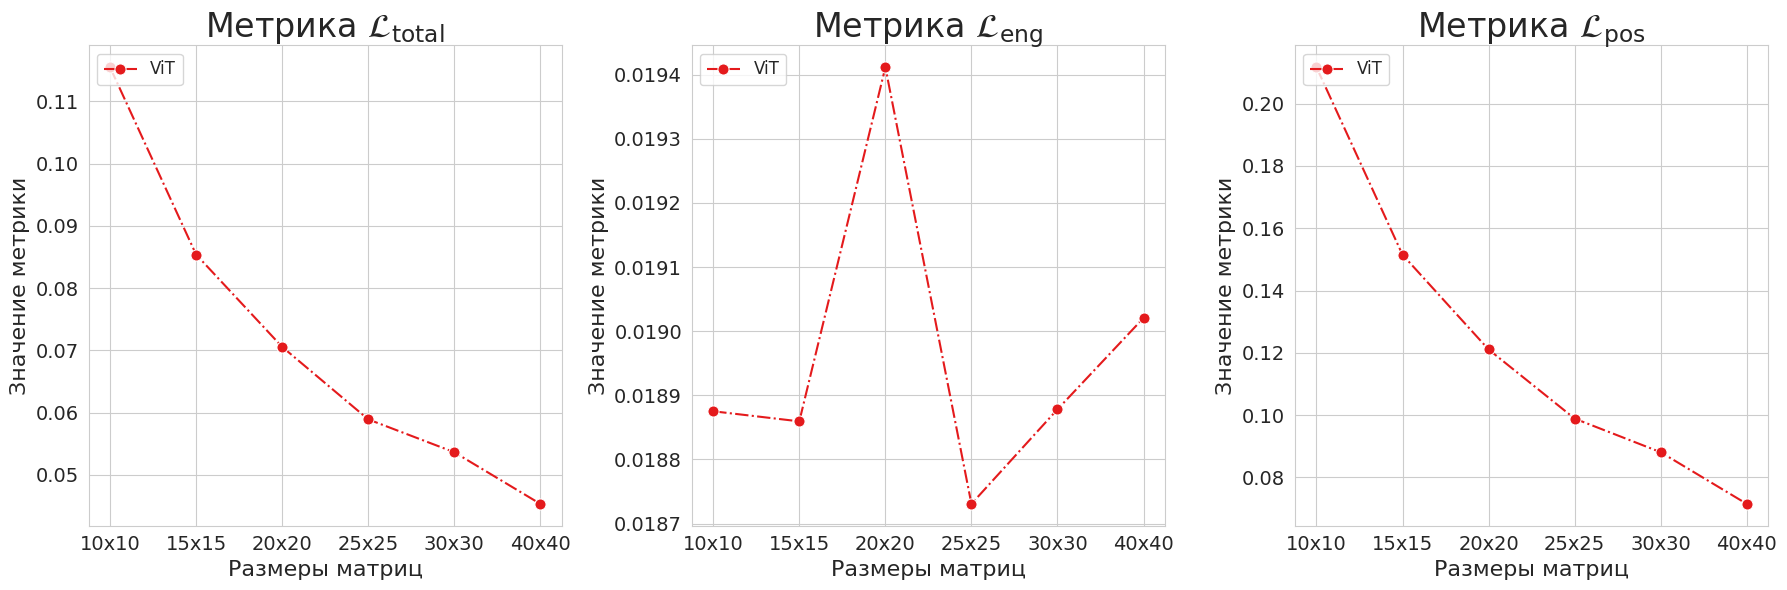

In [59]:
cur_df = runs_df.loc[runs_df['group'].str.startswith('exp6')]

models = {
    "MyViT": "ViT",
}

shapes = sorted(list(set(cur_df['group'].str.split('_').apply(lambda x: x[1]).tolist())))

metrics = {
    'val_total': '$\mathcal{L}_{\mathsf{total}}$',
    'RMSE_E eng': '$\mathcal{L}_{\mathsf{eng}}$',
    'RMSE pos': '$\mathcal{L}_{\mathsf{pos}}$',
}

sns.set_style("whitegrid")

palette = sns.color_palette("Set1", len(models))

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, (metric, latex_metric) in zip(axes, metrics.items()):
    for i, (old_name, name) in enumerate(models.items()):
        values = {shape: [] for shape in shapes}

        for shape in shapes:
            tmp = cur_df.loc[cur_df['group'] == f"exp6_{shape}"]

            tmp = tmp[tmp['summary'].apply(lambda x: metric in x)]

            # changing L_{pos} to be in centimeters
            tmp['val_total'] = tmp['summary'].apply(lambda x: x['val_total'])
            tmp['RMSE_E eng'] = tmp['summary'].apply(lambda x: x['RMSE_E eng'])
            tmp['RMSE pos'] = tmp['summary'].apply(lambda x: x['RMSE pos'])

            tmp['RMSE pos'] = convert(tmp['RMSE pos'], shape)
            tmp['val_total'] = 0.5 * tmp['RMSE_E eng'] + 0.5 * tmp['RMSE pos']

            values[shape] = tmp[metric].tolist()

        sorted_values = sorted(values.items(), key=lambda x: shapes.index(x[0]))

        sorted_shapes, sorted_metrics = zip(*sorted_values)

        sns.lineplot(
            x=sorted_shapes,
            y=[np.min(x) for x in sorted_metrics],
            ax=ax,
            color=palette[i],
            label=name,
            marker='o',
            markersize=8,
            linestyle='-.',
            linewidth=1.5,
        )

    ax.set_title(f"Метрика {latex_metric}", fontsize=24)
    ax.set_xlabel('Размеры матриц', fontsize=16)
    ax.set_ylabel('Значение метрики', fontsize=16)
    ax.legend(fontsize=12, loc='upper left')
    ax.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()
plt.savefig('../graphics/best_vit')
plt.show()